# Neural Spline Flow Tutorial

This notebook is intended as an example of usage of the `NeuralSplineFlow` class from `spqr` module, where we have trained the bijector to replicate a simple 2-D feature distribution. 

## Introduction

A *normalizing flow* is a bijective and differentiable transformation $g_{\theta}$, which can map a vector of features with D-dimensions $x$ in a transformed vector $g_\theta(x) \sim z$ with D-dimension. Since the transformation $g$ is differentiable, the probability distribution of $z$ and $x$ are linked through a simple change of variable:

   $ p(x) = p(z) \cdot det \Bigl(\dfrac{d g_\theta}{d x}\Bigr) $

Hence the name *normalizing*.

The parameters $\theta$ can be trained to map a simple distribution $p(z)$ (tipically a gaussian) into the feature distribution $p(x)$ through the inverse transformation $g_\theta^{-1}$.

Following the idea in the article [Durkan et al.](https://arxiv.org/abs/1906.04032), we have implemented a *normalizing flow* transformation which uses as bijector a [rational quadratic spline](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/RationalQuadraticSpline). To learn the correlation between features (improves the expressivity of the transformation) and to avoid a too large computation time for the Jacobian, bijectors must be composed in chain allowing at each step some variables to be unchanged. The algorithm we use to this purpose is a [RealNVP](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/RealNVP).

## Package required to run this notebook

First, we need to download from the GitHub repository [diglm](https://github.com/MarcoRiggirello/diglm.git) the necessary modules and import the required packages.

In [ ]:
! git clone https://github.com/MarcoRiggirello/diglm.git

In [1]:
import os
import sys

# to find the modules
py_file_location = "diglm/src"
sys.path.append(py_file_location)

import numpy as np
from matplotlib import pyplot as plt
import sklearn.datasets as skd # where we can find a simple example
import tensorflow as tf
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

from spqr import NeuralSplineFlow as NSF

## Toy dataset

We load a simple dataset from `sklearn.datasets`, `moons`. This dataset is often used ([FFJORD demo](https://www.tensorflow.org/probability/examples/FFJORD_Demo)) to illustrate the functioning of a *normalizing flow*.

We also define in this section a function to plot data and visualize them nicely.

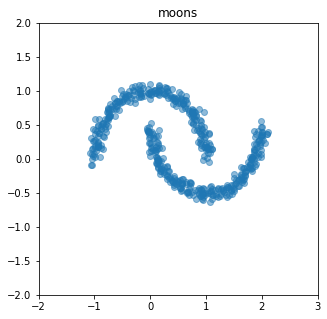

In [2]:
BATCH_SIZE = 256
DATASET_SIZE = BATCH_SIZE * 2
SAMPLE_SIZE = DATASET_SIZE

# load the dataset
moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]
# transform the dataset to a `tf.data.Dataset` object for autobatching,
# multiprocessing, speed up etc... 
moons_ds = tf.data.Dataset.from_tensor_slices(moons.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.batch(BATCH_SIZE)

def plot(sample1, title, name, sample2=None):
    x_s, y_s = np.squeeze(np.split(sample1, 2, axis=1))
    fig, ax_s = plt.subplots(figsize=(5, 5))

    ax_s.scatter(x_s, y_s, alpha=0.5)
    if sample2 is not None:
        x_s2, y_s2 = np.squeeze(np.split(sample2, 2, axis=1))
        ax_s.scatter(x_s2, y_s2, alpha=0.5, color='orange')
    ax_s.set(xlim=(-2, 3), ylim=(-2, 2))
    ax_s.set_title(title)
    plt.savefig(name)

plot(moons, 'moons', "moons.jpeg")
plt.show()

## Initialization of NSF

We initialize the NeuralSplineFlow bijector and define a base distribution $z$ as a multivariate normal distribution with $\mu = [0., 0.]$ and cov = 
$ 
\begin{pmatrix}
1. & 0 \\
0 & 1 \\
\end{pmatrix}
$
Then, we plot the base distribution and its inverse.

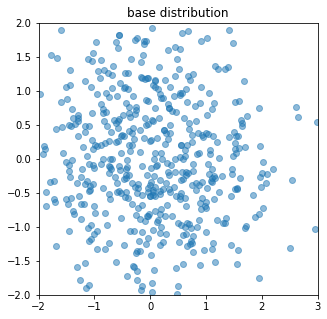

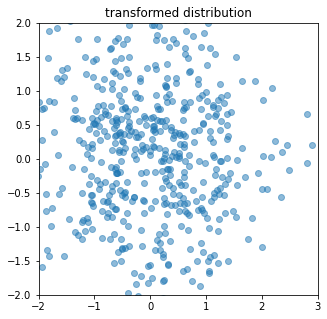

In [3]:
neural_spline_flow = NSF(splits=2) # with 2 features 2 splits is enough 

base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([1., 1.]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
transformed_distribution = tfd.TransformedDistribution(distribution=base_distribution,
                                                       bijector=neural_spline_flow)

# plotting
plot(base_distribution.sample(SAMPLE_SIZE), 'base distribution', 'base_distr.jpeg')
plot(transformed_distribution.sample(SAMPLE_SIZE), 'transformed distribution', 'trans_distr.jpeg')
plt.show()

##  Model training

We define a train step function following the [keras example](https://keras.io/guides/writing_a_training_loop_from_scratch/). With a normalizing flow it is straightforward to choose the objective function to minimize:

$ - \sum \log{p(x_i; \theta)}$

In [4]:
LR = .6e-3
NUM_EPOCHS = 300

@tf.function
def train_step(optimizer, target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

We are ready to perform the training!

In [5]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss = 0
fig_list = []

# Training loop
for epoch in range(NUM_EPOCHS):
    if epoch % 10 == 9:
        print(f"Epoch n. {epoch+1}. Loss={loss}.")
        fig_name = f"fig{epoch+1}.jpeg"
        fig_list.append(fig_name)
        plot(transformed_distribution.sample(SAMPLE_SIZE), 'transformed vs moon', fig_name, moons)
    for batch in moons_ds:
        loss = train_step(optimizer, batch)
    

KeyboardInterrupt: 

## Conclusion and results

Here we summarize the results of the training:

1. we plot the history of the loss during the training;
3. Using the `make_gif` function we realize a gif of the evolution of the transformed distribution during training.


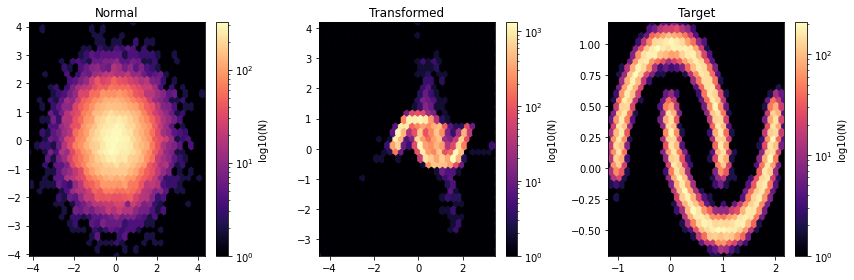

In [ ]:
from plot_utils import make_gif

make_gif(fig_list, output_gif="spqr.gif")